In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch.nn.functional as F
import re

GD LSA Helpers

In [3]:
def generate_perfect_data(input_dim, num_contexts, W_true):
    """
    Generates perfect data for a given task using the ground-truth weight W_true.
    """
    # Generate context inputs uniformly from [-1, 1]
    X_context = torch.rand(num_contexts - 1, input_dim) * 2 - 1  # Shape: (num_contexts - 1, input_dim)
    y_context = X_context @ W_true.T  # Shape: (num_contexts - 1, 1)

    # Generate query input uniformly from [-1, 1]
    X_query = torch.rand(1, input_dim) * 2 - 1  # Shape: (1, input_dim)
    y_query = X_query @ W_true.T  # Shape: (1, 1)

    return X_context, y_context, X_query, y_query


def construct_gd_lsa_weights(input_dim, output_dim, learning_rate, num_contexts, W0):
    """
    Constructs the weight matrices for the GD LSA model based on Proposition 1.

    Args:
        input_dim: Dimensionality of input x (nI).
        output_dim: Dimensionality of output y (nO).
        learning_rate: Learning rate for gradient descent.
        num_contexts: Number of context tokens (N).
        W0: Initial regression weight matrix (output_dim x input_dim).
            If None, defaults to zero matrix.

    Returns:
        W_K, W_Q, W_V, P: Weight matrices for the GD LSA layer.
    """
    Ix = torch.eye(input_dim)  # Identity matrix for x
    Iy = torch.eye(output_dim)  # Identity matrix for y

    # Key and Query Matrices
    W_K = W_Q = torch.block_diag(Ix, torch.zeros(output_dim, output_dim))

    # Value Matrix
    W_V = torch.cat([
        torch.cat([torch.zeros(input_dim, input_dim), torch.zeros(input_dim, output_dim)], dim=1),
        torch.cat([W0, -Iy], dim=1)
    ], dim=0)

    # Projection Matrix
    P = (learning_rate / num_contexts) * torch.eye(input_dim + output_dim)

    return W_K, W_Q, W_V, P


class ConstructedLinearSelfAttention(nn.Module):
    def __init__(self, input_dim, learning_rate, num_contexts, W0):
        super(ConstructedLinearSelfAttention, self).__init__()
        self.input_dim = input_dim
        self.combined_dim = input_dim + 1  # Since output_dim is 1

        # Construct the weight matrices
        W_K, W_Q, W_V, P = construct_gd_lsa_weights(
            input_dim, 1, learning_rate, num_contexts, W0
        )

        # Register the weight matrices as buffers
        self.register_buffer('W_k', W_K)
        self.register_buffer('W_q', W_Q)
        self.register_buffer('W_v', W_V)
        self.register_buffer('P', P)

    def forward(self, context, query):
        K = context @ self.W_k.T
        Q = query @ self.W_q.T
        V = context @ self.W_v.T

        # Attention mechanism
        attention_scores = Q @ K.T
        attention_weights = attention_scores / K.size(1)
        context_update = attention_weights @ V

        # Apply projection matrix
        output = query + context_update @ self.P.T

        # Extract the prediction (the last element)
        y_pred = output[:, -1:]  # Shape: (1, 1)
        return y_pred

Finding Optimal Learning Rate for GD LSA

In [4]:
def find_best_learning_rate(max_steps=20, num_trials=10000):
    input_dim = 10      # Dimension of x
    output_dim = 1      # Dimension of y
    num_contexts = 32   # Number of context tokens (excluding the query token)

    # Define the range of learning rates to test
    learning_rates = torch.linspace(0.001, 40, steps=max_steps).tolist()

    avg_errors = []

    for lr in learning_rates:
        total_error = 0.0

        for trial in range(num_trials):
            # Initialize W0 (initial weight matrix) as zero matrix
            W0 = torch.zeros(output_dim, input_dim)  # Shape: (1, input_dim)

            # Generate a new ground-truth weight W_true for the task
            W_true = torch.randn(output_dim, input_dim)  # Shape: (1, input_dim)

            # Generate perfect data for this task
            X_context, y_context, X_query, y_query = generate_perfect_data(
                input_dim, num_contexts, W_true
            )

            # Prepare context and query tokens
            init_y_query = -W0 @ X_query.T  # Shape: (1, 1)
            context = torch.cat((X_context, y_context), dim=1)  # Shape: (num_contexts - 1, input_dim + output_dim)
            query = torch.cat((X_query, init_y_query), dim=1)   # Shape: (1, input_dim + output_dim)

            # Instantiate ConstructedLinearSelfAttention
            model = ConstructedLinearSelfAttention(
                input_dim, lr, num_contexts - 1, W0
            )

            # Forward pass
            y_pred = -model(context, query)  # Multiply by -1 to read out prediction

            # Compute the error (Mean Squared Error)
            error = F.mse_loss(y_pred, y_query)

            # Accumulate the error
            total_error += error.item()

        # Compute the average error for this learning rate
        avg_error = total_error / num_trials
        avg_errors.append(avg_error)
        print(f"Learning rate: {lr:.5f}, Average error: {avg_error:.5f}")

    # Find the learning rate with the lowest average error
    min_error = min(avg_errors)
    min_error_index = avg_errors.index(min_error)
    best_learning_rate = learning_rates[min_error_index]

    print(f"\nBest learning rate: {best_learning_rate}")
    print(f"Minimum average error: {min_error}")

    return best_learning_rate, learning_rates, avg_errors


# Run the function to find the best learning rate
best_lr, lr_list, avg_error_list = find_best_learning_rate(max_steps=10, num_trials=10000)

Learning rate: 0.00100, Average error: 3.29356
Learning rate: 4.44533, Average error: 2.49091
Learning rate: 8.88967, Average error: 1.85975
Learning rate: 13.33400, Average error: 1.36670
Learning rate: 17.77833, Average error: 1.03073
Learning rate: 22.22267, Average error: 0.82507
Learning rate: 26.66700, Average error: 0.80084
Learning rate: 31.11133, Average error: 0.97733
Learning rate: 35.55567, Average error: 1.24733
Learning rate: 40.00000, Average error: 1.70104

Best learning rate: 26.66699981689453
Minimum average error: 0.8008405286166117


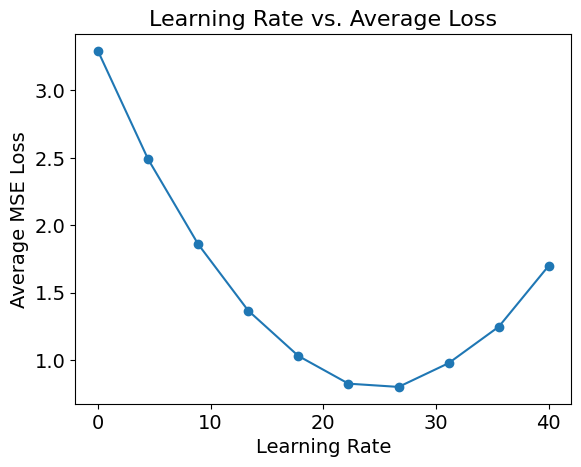

In [5]:
plt.plot(lr_list, avg_error_list, marker='o')
plt.xlabel('Learning Rate', fontsize=14)
plt.ylabel('Average MSE Loss', fontsize=14)
plt.title('Learning Rate vs. Average Loss', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

Trained LSA Helpers

In [6]:
class LinearSelfAttention(nn.Module):
    def __init__(self, input_dim):
        """
        input_dim: Dimension of concatenated x tokens
        """
        super(LinearSelfAttention, self).__init__()
        combined_dim = input_dim + 1
        self.W_k = nn.Linear(combined_dim, combined_dim, bias=False)
        self.W_q = nn.Linear(combined_dim, combined_dim, bias=False)
        self.W_v = nn.Linear(combined_dim, combined_dim, bias=False)
        self.P = nn.Linear(combined_dim, 1, bias=False)

    def forward(self, context, query):
        # Compute Keys, Queries, and Values
        K = self.W_k(context)  # Shape: (N, combined_dim)
        Q = self.W_q(query)    # Shape: (1, combined_dim)
        V = self.W_v(context)  # Shape: (N, combined_dim)

        # Attention mechanism
        attention_scores = Q @ K.T  # Shape: (1, N)
        attention_weights = attention_scores / torch.sqrt(torch.tensor(K.size(1), dtype=torch.float))
        context_update = attention_weights @ V  # Shape: (1, combined_dim)

        # Apply projection matrix
        output = self.P(context_update)  # Shape: (1, 1)
        return output

Training loop

In [7]:
def train_lsa_multi_setup(
    input_dim,
    num_contexts,
    loss_fn,
    epochs,
    batch_size,
    constructed_lr,
    setups   # List of tuples: (model, noise_level, optimizer)
):
    """
    Trains multiple LSA models with different noise levels and computes constructed LSA loss for each setup.

    Args:
        input_dim: Dimensionality of input x.
        num_contexts: Total number of data samples (contexts + 1 query).
        loss_fn: Loss function to use.
        epochs: Number of epochs to train.
        constructed_lr: Learning rate for the constructed LSA model.
        setups: List of tuples, each containing (model, noise_level, optimizer).

    Returns:
        loss_dict: Dictionary of training losses for each setup, including constructed LSA.
    """
    # Initialize loss dictionary
    loss_dict = {}
    for model, noise_level, _ in setups:
        key = f"{type(model).__name__}_sigma_{noise_level}"
        loss_dict[key] = []
    loss_dict["constructed"] = []

    for epoch in range(epochs):
        # Initialize accumulators for losses
        batch_loss = {key: 0.0 for key in loss_dict.keys()}

        for _ in range(batch_size):
            # Generate a new ground-truth weight W0 for the task
            W0 = torch.randn(1, input_dim)  # Shape: (1, input_dim)

            # Generate perfect data for this task
            X_context, y_context, X_query, y_query = generate_perfect_data(
                input_dim, num_contexts, W0
            )

            # For constructed LSA model
            # Prepare context and query tokens
            W0_constructed_lsa = torch.zeros(1, input_dim)    # W0 = zero matrix
            init_y_query = - W0_constructed_lsa @ X_query.T  # Shape: (1, 1), times -1 for easier reading out prediction
            context = torch.cat((X_context, y_context), dim=1)  # Shape: (num_contexts - 1, input_dim + 1)
            query = torch.cat((X_query, init_y_query), dim=1)  # Shape: (1, input_dim + 1)

            # Instantiate ConstructedLinearSelfAttention
            constructed_model = ConstructedLinearSelfAttention(
                input_dim, constructed_lr, num_contexts - 1, W0=W0_constructed_lsa
            )

            # Forward pass for constructed model
            constructed_prediction = -constructed_model(context, query)   # times -1 to read out prediction

            # Compute loss
            constructed_loss = loss_fn(constructed_prediction, y_query)

            # Accumulate constructed loss
            batch_loss["constructed"] += constructed_loss.item()

            # Iterate over different model+noise setups
            for model, noise_level, optimizer in setups:
                model.train()
                # Add noise to y_context for this setup (no noise if noise_level = 0.0)
                noisy_y_context = y_context + torch.randn_like(y_context) * noise_level

                # Prepare context and query tokens
                context = torch.cat((X_context, noisy_y_context), dim=1)  # Shape: (num_contexts - 1, input_dim + 1)
                query = torch.cat((X_query, torch.zeros_like(y_query)), dim=1)  # Shape: (1, input_dim + 1)

                # Forward pass
                predictions = model(context, query)  # Expected output shape depends on model

                # Compute loss
                loss = loss_fn(predictions, y_query)

                # Training step for trained model
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                # Accumulate loss
                key = f"{type(model).__name__}_sigma_{noise_level}"
                batch_loss[key] += loss.item()

        # After batch_size tasks, average the losses
        for key in loss_dict.keys():
            avg_loss = batch_loss[key] / batch_size
            loss_dict[key].append(avg_loss)

        # Logging
        if (epoch + 1) % 1 == 0:
            print(f"Epoch [{epoch + 1}/{epochs}] Losses:")
            for key in loss_dict.keys():
                print(f"  {key}: {loss_dict[key][-1]:.6f}")

    return loss_dict

Train

In [11]:
# Define parameters
input_dim = 10
num_contexts = 32  # Includes 10 contexts + 1 query
epochs = 150
batch_size = 1000
learning_rate = 0.0001
constructed_lr = 26.667

# Define loss function
loss_fn = nn.MSELoss()

# Initialize models and optimizers
model1 = LinearSelfAttention(input_dim)
optimizer1 = torch.optim.SGD(model1.parameters(), lr=learning_rate)

model2 = LinearSelfAttention(input_dim)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=learning_rate)

model3 = LinearSelfAttention(input_dim)
optimizer3 = torch.optim.SGD(model3.parameters(), lr=learning_rate)

model4 = LinearSelfAttention(input_dim)
optimizer4 = torch.optim.SGD(model4.parameters(), lr=learning_rate)

model5 = LinearSelfAttention(input_dim)
optimizer5 = torch.optim.SGD(model5.parameters(), lr=learning_rate)

# Setups: List of tuples (model, noise_level, optimizer)
setups = [
    (model1, 0.0, optimizer1),  # No noise
    (model2, 0.05, optimizer2),  # Low noise
    (model3, 0.1, optimizer3),  # Medium noise
    (model4, 0.15, optimizer4),  # High noise
    (model5, 0.2, optimizer5),  # High+ noise
]

# Train the models
loss_dict = train_lsa_multi_setup(
    input_dim=input_dim,
    num_contexts=num_contexts,
    loss_fn=loss_fn,
    epochs=epochs,
    batch_size=batch_size,
    constructed_lr=constructed_lr,
    setups=setups
)

Epoch [1/150] Losses:
  LinearSelfAttention_sigma_0.0: 3.199949
  LinearSelfAttention_sigma_0.05: 3.150353
  LinearSelfAttention_sigma_0.1: 3.190736
  LinearSelfAttention_sigma_0.15: 3.172287
  LinearSelfAttention_sigma_0.2: 3.166070
  constructed: 0.769546
Epoch [2/150] Losses:
  LinearSelfAttention_sigma_0.0: 3.418841
  LinearSelfAttention_sigma_0.05: 3.292021
  LinearSelfAttention_sigma_0.1: 3.300218
  LinearSelfAttention_sigma_0.15: 3.338987
  LinearSelfAttention_sigma_0.2: 3.212818
  constructed: 0.822418
Epoch [3/150] Losses:
  LinearSelfAttention_sigma_0.0: 3.210391
  LinearSelfAttention_sigma_0.05: 3.191122
  LinearSelfAttention_sigma_0.1: 3.164578
  LinearSelfAttention_sigma_0.15: 3.216952
  LinearSelfAttention_sigma_0.2: 3.179082
  constructed: 0.836688
Epoch [4/150] Losses:
  LinearSelfAttention_sigma_0.0: 3.628678
  LinearSelfAttention_sigma_0.05: 3.671330
  LinearSelfAttention_sigma_0.1: 3.515074
  LinearSelfAttention_sigma_0.15: 3.669952
  LinearSelfAttention_sigma_0.2: 3

Plot Loss vs Epochs

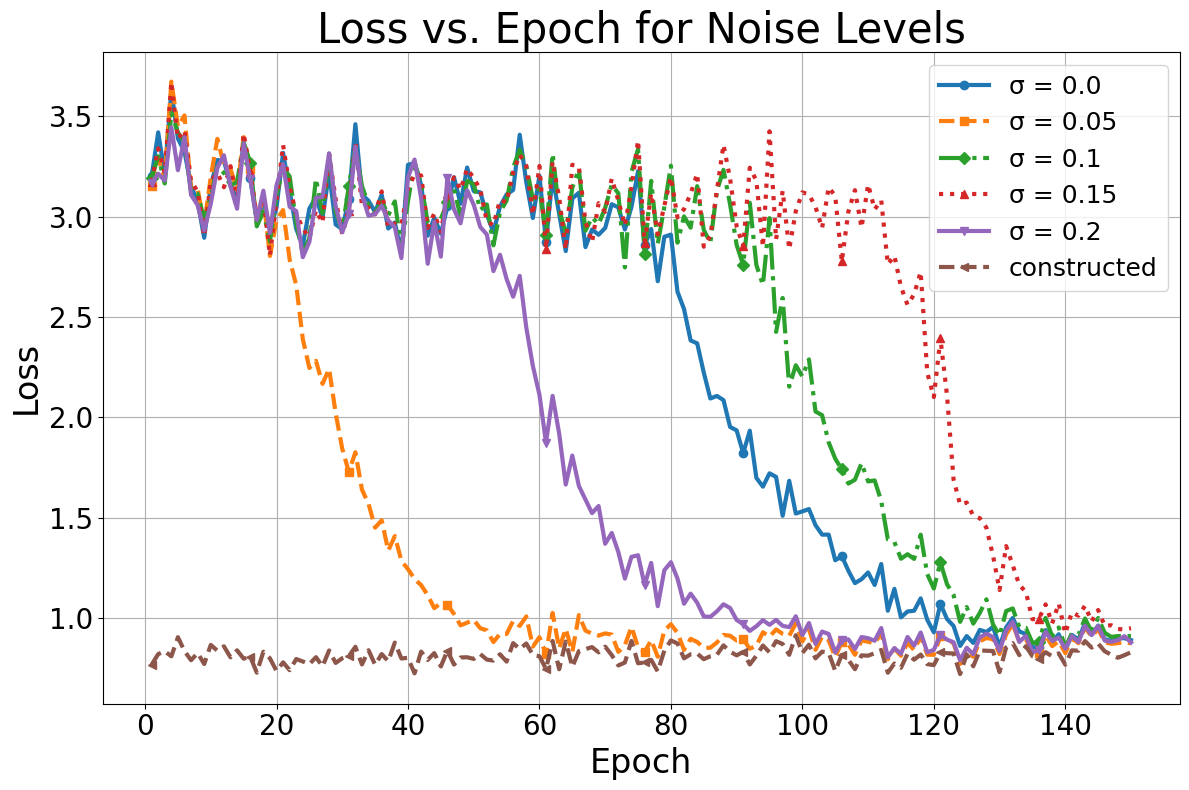

In [17]:
def plot_loss_curves(loss_dict):
    """
    Plots the loss curves from the loss_dict with epochs on the x-axis and loss on the y-axis.

    Args:
        loss_dict: Dictionary containing loss values for different setups.
    """
    # Determine the number of epochs
    num_epochs = len(next(iter(loss_dict.values())))
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(12, 8))

    # Define line styles and markers
    line_styles = ['-', '--', '-.', ':']
    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', '+']

    # Generate a list of colors
    colors = list(mcolors.TABLEAU_COLORS.values())

    for idx, (key, losses) in enumerate(loss_dict.items()):

        # Check if the key corresponds to an LSA model
        if 'LinearSelfAttention' in key:
            # Extract the sigma value from the key using regex
            match = re.search(r'sigma[_=]?([\d\.]+)', key)
            if match:
                sigma_value = match.group(1)
                label = f'σ = {sigma_value}'
            else:
              label = key
        else:
            label = key

        plt.plot(
            epochs,
            losses,
            label=label,
            color=colors[idx % len(colors)],
            linestyle=line_styles[idx % len(line_styles)],
            linewidth=3,
            marker=markers[idx % len(markers)],
            markevery=max(num_epochs // 10, 1)  # Mark every N points
        )

    # Add labels and title
    plt.xlabel('Epoch', fontsize=24)
    plt.ylabel('Loss', fontsize=24)
    plt.title('Loss vs. Epoch for Noise Levels', fontsize=30)
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.legend(fontsize=18)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_loss_curves(loss_dict)

Compare Predictions and Sensitivities

In [14]:
eval_setups = [
    (model1, 0.0, 'σ = 0.0'),  # No noise
    (model2, 0.05, 'σ = 0.05'),  # Low noise
    (model3, 0.1, 'σ = 0.1'),  # Medium noise
    (model4, 0.15, 'σ = 0.15'),  # High noise
    (model5, 0.2, 'σ = 0.2'),  # High+ noise
]

# Dictionary to store cumulative L2 differences
l2_differences = {name: 0.0 for _, _, name in eval_setups}
cosine_similarities = {name: 0.0 for _, _, name in eval_setups}
gradient_differences = {name: 0.0 for _, _, name in eval_setups}

num_trials = 10000    # Number of trials


for trial in range(num_trials):

    # Generate a new test task
    W_test = torch.randn(1, input_dim)  # Ground-truth weight for test task

    # Generate perfect data (context and query tokens) without adding noise
    X_context, y_context, X_query, y_query = generate_perfect_data(
        input_dim, num_contexts, W_test
    )

    # Ensure X_query requires gradient
    X_query.requires_grad = True

    # Initialize GD LSA with W0 = 0
    W0 = torch.zeros(1, input_dim)  # Initial weight matrix for GD LSA

    # Instantiate the GD LSA model
    gd_lsa_model = ConstructedLinearSelfAttention(
        input_dim, constructed_lr, num_contexts - 1, W0
    )

    # Prepare context tokens
    context = torch.cat([X_context, y_context], dim=1)  # Shape: (num_contexts - 1, combined_dim)

    # Prepare initial y query token for GD LSA (since W0 is zero, this is zero)
    init_y_query = -W0 @ X_query.T
    init_y_query = init_y_query.T  # Shape: (1, output_dim)

    # Prepare query token
    query = torch.cat([X_query, init_y_query], dim=1)  # Shape: (1, combined_dim)

    # Get predictions from GD LSA
    y_pred_gdlsa = -gd_lsa_model(context, query)  # Multiply by -1 to extract prediction

    # Compute gradient of GD LSA prediction w.r.t X_query
    grad_gdlsa = torch.autograd.grad(y_pred_gdlsa, X_query, grad_outputs=torch.ones_like(y_pred_gdlsa), create_graph=True)[0]

    # For each model in eval_setups
    for model, _, name in eval_setups:
        # Ensure the model is in evaluation mode
        model.eval()

        # Reset gradients for X_query
        X_query.grad = None

        # Prepare context and query tokens
        context_model = torch.cat((X_context, y_context), dim=1)  # Shape: (num_contexts - 1, input_dim + 1)
        query_model = torch.cat((X_query, torch.zeros_like(y_query)), dim=1)  # Shape: (1, input_dim + 1)

        # Get predictions from the trained model
        y_pred_model = model(context_model, query_model)  # Expected output shape depends on model

        # Compute gradient of the model's prediction w.r.t X_query
        grad_model = torch.autograd.grad(y_pred_model, X_query, grad_outputs=torch.ones_like(y_pred_model), create_graph=True)[0]

        # Compute L2 norm of the difference between predictions
        l2_diff = torch.norm(y_pred_model - y_pred_gdlsa, p=2).item()

        # Accumulate the L2 difference
        l2_differences[name] += l2_diff

        # Compute cosine similarity between the gradients
        cosine_sim = F.cosine_similarity(grad_model, grad_gdlsa, dim=1).item()
        cosine_similarities[name] += cosine_sim

        # Compute L2 norm of the difference between gradients
        grad_diff = torch.norm(grad_model - grad_gdlsa, p=2).item()
        gradient_differences[name] += grad_diff

# Calculate average L2 differences across trials
avg_l2_differences = {name: total_l2_diff / num_trials for name, total_l2_diff in l2_differences.items()}
avg_cosine_similarities = {name: total / num_trials for name, total in cosine_similarities.items()}
avg_gradient_differences = {name: total / num_trials for name, total in gradient_differences.items()}

# Print average L2 differences
print("\nAverage L2 Differences between Trained Models and GD LSA Predictions:")
for name, avg_l2_diff in avg_l2_differences.items():
    print(f"{name}: {avg_l2_diff}")

# Print average cosine similarities
print("\nAverage Cosine Similarities between Sensitivities:")
for name, avg_cosine_sim in avg_cosine_similarities.items():
    print(f"{name}: {avg_cosine_sim}")

# Print average L2 differences between gradients
print("\nAverage L2 Differences between Sensitivities:")
for name, avg_grad_diff in avg_gradient_differences.items():
    print(f"{name}: {avg_grad_diff}")


Average L2 Differences between Trained Models and GD LSA Predictions:
σ = 0.0: 0.18570792486249701
σ = 0.05: 0.16320271317497828
σ = 0.1: 0.18472488376731053
σ = 0.15: 0.21162861087573692
σ = 0.2: 0.1669112719663419

Average Cosine Similarities between Sensitivities:
σ = 0.0: 0.9911111714839935
σ = 0.05: 0.9932837995350361
σ = 0.1: 0.9910746951401234
σ = 0.15: 0.9859682068884372
σ = 0.2: 0.9929657451748848

Average L2 Differences between Sensitivities:
σ = 0.0: 0.40134758558645844
σ = 0.05: 0.35227482510395347
σ = 0.1: 0.39827856924161315
σ = 0.15: 0.4572435876175761
σ = 0.2: 0.3600447805263102
